# Modelos Lineales - Parte 2. Clasificación

<h1>Índice<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Clasificación-como-reducción-de-la-dimensión" data-toc-modified-id="Clasificación-como-reducción-de-la-dimensión-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Clasificación como reducción de la dimensión</a></span></li><li><span><a href="#Discriminante-lineal-de-Fischer" data-toc-modified-id="Discriminante-lineal-de-Fischer-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Discriminante lineal de Fischer</a></span><ul class="toc-item"><li><span><a href="#Solución-analítica" data-toc-modified-id="Solución-analítica-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Solución analítica</a></span></li></ul></li><li><span><a href="#Perceptrón" data-toc-modified-id="Perceptrón-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Perceptrón</a></span><ul class="toc-item"><li><span><a href="#Stochastic-Gradient-Descent-(SGD)" data-toc-modified-id="Stochastic-Gradient-Descent-(SGD)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Stochastic Gradient Descent (SGD)</a></span></li><li><span><a href="#Optimización-del-perceptrón" data-toc-modified-id="Optimización-del-perceptrón-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Optimización del perceptrón</a></span></li></ul></li><li><span><a href="#Qué-es-linealmente-separable" data-toc-modified-id="Qué-es-linealmente-separable-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Qué es linealmente separable</a></span></li><li><span><a href="#Datos-de-MNIST" data-toc-modified-id="Datos-de-MNIST-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Datos de MNIST</a></span><ul class="toc-item"><li><span><a href="#Clasificación-binaria" data-toc-modified-id="Clasificación-binaria-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Clasificación binaria</a></span></li><li><span><a href="#Extras" data-toc-modified-id="Extras-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Extras</a></span></li></ul></li></ul></div>

Primero, corremos la celda de preparación.

In [420]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "07_Clasificación"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Clasificación como reducción de la dimensión

$\newcommand{\vv}[1]{\boldsymbol{#1}}$
$\newcommand{\om}[0]{\boldsymbol{\omega}}$
$\newcommand{\norm}[0]{\mathcal{N}}$
$\newcommand{\b}[1]{\mathrm{\mathbf{#1}}}$
$\newcommand{\T}{^\mathrm{T}}$
$\newcommand{\cu}{\mathcal{C}_1}$
$\newcommand{\cd}{\mathcal{C}_2}$

La clasificación puede pensarse como un proceso de reducción de la dimensión de los datos. La clasificación consiste en tomar un dato vectorial, $\mathbf{x}$, y convertirlo a un valor unidimensional (y discreto), que corresponde a su clase, $y$.

En el caso de un modelo lineal y un problema de clasificación binaria tenemos que

$$
y = \om\T \boldsymbol{x}\;\;,
$$
donde ahora no incluimos a $\omega_0$ en el vector $\om$. En cambio, el valor $-\omega_0$ sirve como umbral para la clasificación. Si $y \geq -\omega_0$, asignamos el dato a la clase $\cu$, de lo contrario, lo asignamos a la clase $\cd$.

***

Veamos un ejemplo de este tema de la proyección.

Creemos un set aleatorio en dos dimensiones, compuesto de dos clases, cuya distribución es multinormal

$$
p(\mathbf{x} | C_k) = \mathcal{N}(\vv{\mu}_k, \vv{\Sigma}_k)\;\;.
$$

Esto es lo que se llama un modelo generativo. Pero acá, en lugar de usarlo para clasificar, lo estamos usando para generar datos. Por supuesto, si supieramos a priori que esta es la distribución, podríamos usar las técnicas que vamos a ver más adelante.

Elijamos parámetros a ojo, y muestremos elementos de cada clase.

In [421]:
from numpy.random import multivariate_normal

size1 = 250
mu1 = [0, 0]
cov1 = [[1, 0.95],[0.95, 1]]

size2 = 200
mu2 = [-3, 0.5]
cov2 = [[1, 0.8],[0.8, 1]]

np.random.seed(20200922)
# Sample classes
xc1 = multivariate_normal(mean=mu1, cov=cov1, size=size1).T
xc2 = multivariate_normal(mean=mu2, cov=cov2, size=size2).T

print(xc1.shape, xc2.shape)

(2, 250) (2, 200)


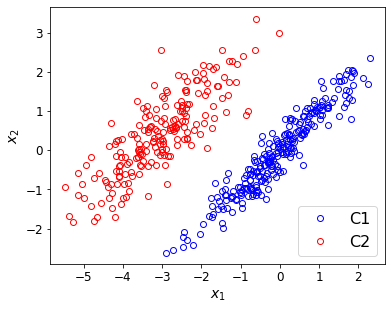

In [422]:
# Veamos cómo se ven
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.plot(*xc1, 'ob', mfc='None', label='C1')
ax.plot(*xc2, 'or', mfc='None', label='C2')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend(loc='lower right', fontsize=16)
ax.set_aspect('equal')

Claramente, si proyectamos, digamos sobre el eje de $x_1$, las clases no se separan muy bien.

Text(0.5, 0, '$y$')

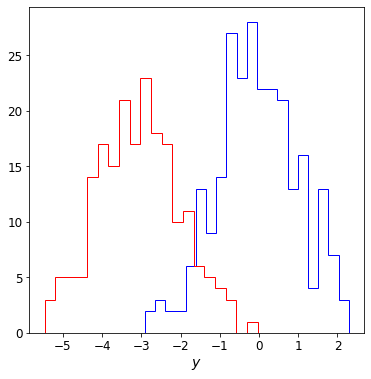

In [423]:
# Veamos cómo se ven
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

nbins = 20
ax.hist(xc1[0], nbins, histtype='step', color='b')
ax.hist(xc2[0], nbins, histtype='step', color='r')

ax.set_xlabel('$y$')

Uno puede entonces preguntarse en qué dirección hay que proyectar los datos para tener la mejor separación entre clases. Y también cabe la pregunta de qué quiere uno decir por "separación entre clases".

Una idea intuitiva es decir que, una vez proyectados, los centros de las distribuciones se encuentren lo más separados posible. Recuerden que la frontera de decisión es perpendicular a $\om$:

<img width=450px, src='images/Figure4.1.png'>

Entonces, la operación $y = \om\T \mathbf{x}$ consiste en realizar la proyección sobre la dirección definida por el vector $\om$, y los centros de los datos pertenecientes a cada clase, una vez proyectados, son:

$$
m_k = \om\T \mathbf{m}_k\;\;,
$$
donde
$$
\mathbf{m}_k = \frac{1}{N_k}\sum_{i \in \mathcal{C}_k}\mathbf{x}_i\;\;.
$$

Entonces, tenemos que elegir $\om$ que maximise

$$
m_2 - m_1 = \om\T \left(\mathbf{m}_2 - \mathbf{m}_1\right)\;\;,
$$

pero como esta expresión puede hacerse tan grande como uno quiera, aumentando el módulo de $\om$, ponemos la condición de que el vector de los pesos esté normalizado:

$$
\sum_{i=1}^D \omega_i^2 = 1\;\;,
$$
donde $D$ es la dimensión del espacio de los datos (es decir, los elementos de *un* vector de datos $\mathbf{x}$). 

Podemos entonces maximizar la distancia $m_2 - m_1$ con esa condición, usando multiplicadores de Lagrange (es el Ejercicio 4.4 del Bishop, que está resuelto [online](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/05/prml-web-sol-2009-09-08.pdf). El resultado es que

$$
\om \propto \left(\mathbf{m}_1 - \mathbf{m}_2\right)\;\;,
$$

es decir, que hay que proyectar a lo largo de la línea que separa los centros de las distribuciones de cada clase. Esto está al revés que en el Bishop, porque la respuesta completa es proporcional a $\left(\mathbf{m}_1 - \mathbf{m}_2\right)$, pero con una constante negativa. Veamos...

In [424]:
# Calculo las medias muestrales (son vectores!)
m1_ = xc1.mean(axis=1).reshape(-1, 1)
m2_ = xc2.mean(axis=1).reshape(-1, 1)

# Hago la resta y normalizo (por amor al arte)
# Cambio el signo con respecto a 
dm = m1_ - m2_
w = dm / np.sqrt(np.dot(dm.T, dm))

# Veámoslo!
print(w)

[[ 0.98757834]
 [-0.15712739]]


In [425]:
# Definamos una función práctica
def plot_clasi(x, t, ws, labels=[], xp=[-1., 1.], thr=0, spines='zero', equal=True):
    """
    Figura con el resultado del ajuste lineal
    """
    assert len(labels) == len(ws) or len(labels) == 0
    
    if len(labels) == 0:
        labels = np.arange(len(ws)).astype('str')
    
    # Agregemos el vector al plot
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    
    xc1 = x[:, t[0] == 1]
    xc2 = x[:, t[0] == 0]
    
    ax.plot(*xc1, 'ob', mfc='None', label='C1')
    ax.plot(*xc2, 'or', mfc='None', label='C2')

    for i, w in enumerate(ws):
        
        # Ploteo vector de pesos
        x0 = 0.5 * (xp[0] + xp[1])
        ax.quiver(0, thr/w[1], w[0], w[1], color='C{}'.format(i+2), scale=10, label=labels[i],
                 zorder=10)

        # ploteo plano perpendicular
        xp = np.array(xp)
        yp = (thr -w[0]*xp)/w[1] 

        plt.plot(xp, yp, '-', color='C{}'.format(i+2))
        
    # Ploteo línea que une centros de los conjuntos
    mu1 = xc1.mean(axis=1)
    mu2 = xc2.mean(axis=1)
    ax.plot([mu1[0], mu2[0]], [mu1[1], mu2[1]], 'o:k', mfc='None', ms=10)

#     ax.set_xlabel('$x_1$')
#     ax.set_ylabel('$x_2$')
    ax.legend(loc=0, fontsize=16)
    if equal:
        ax.set_aspect('equal')
    
    if spines is not None:
        for a in ['left', 'bottom']:
            ax.spines[a].set_position('zero')
        for a in ['top', 'right']:
            ax.spines[a].set_visible(False)
        
#     ax.set_xlim(-7, 3)
#     ax.set_ylim(-4, 4)
    return

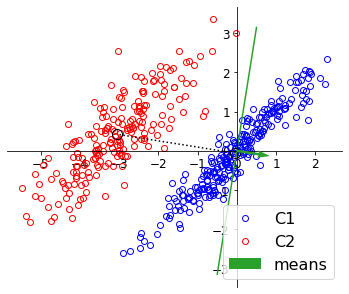

In [426]:
# Juntamos todo en un solo vector porque así lo podemos usar con la función de recién
x = np.hstack([xc1, xc2])
tc1 = np.ones((1, xc1.shape[1]))
tc2 = np.zeros((1, xc2.shape[1]))
# tc2 = -np.ones((1, xc2.shape[1]))
t = np.hstack([tc1, tc2])

plot_clasi(x, t, [w,], labels=['means',], xp=[-0.5, 0.5], spines='zero')

Text(0.5, 0, '$y$')

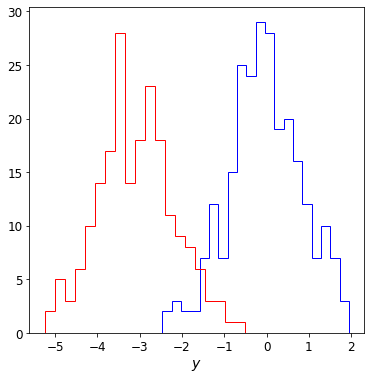

In [427]:
# Veamos la proyección de lo largo de esa dirección
y1 = np.dot(w.T, xc1)
y2 = np.dot(w.T, xc2)

#print(y1.shape, y2.shape)

# Veamos cómo se ven
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

nbins = 20
ax.hist(y1[0], nbins, histtype='step', color='b')
ax.hist(y2[0], nbins, histtype='step', color='r')

ax.set_xlabel('$y$')

Quedaría elegir el valor del umbral $-\omega_0$ a partir del cual separamos las clases. Pero vemos que, no importa cómo lo elijamos, y a pesar de que el conjunto de datos es separable linealmente, este criterio no alcanza para separar las clases completamente. 

Pero no hay que desesperar, ya llega....

## Discriminante lineal de Fischer

La idea del discriminante lineal de Fischer es aumentar la separación de las clases, a la vec que uno disminuye la varianza de cada una de ellas, de forma de que los histogramas de cada clase sean lo más angosto posible.

El criterio de Fischer es

\begin{equation}
J(\om) = \frac{\left(m_2 - m_1\right)^2}{s_1^2 + s_2^2}\;\;,
\label{fischer1}
\end{equation}
donde 
$$
s^2_k = \sum_{i\in\mathcal{C}_k}\left(y_k - m_k\right)^2
$$
es la varianza muestral intra-clase.

Ahora en un ratito vemos cómo maximizar $J(\om)$ con respecto a $\om$ y tener el resultado analítico. Pero aprovechemos las computadoras para ganar un poco de intuición al respecto.

Veamos primero que el vector $\om$, dado que está normalizado, podemos parametrizarlo con un ángulo, $\theta$, medido en sentido contrario a las agujas del reloj desde $x_1$ positivos:
$$
\om = (\cos(\theta), \sin(\theta))\;\;.
$$

Y calculemos el numerador y denominador de $J(\om)$ para varios valores de $\theta$

In [428]:
theta = np.linspace(-np.pi, np.pi, 500)
num = np.zeros_like(theta)
den = np.zeros_like(theta)

for i, th in enumerate(theta):
    om = np.array([np.cos(th), np.sin(th)]).reshape(-1, 1)
    
    # Calculamos las proyeccciones de los centros y su diferencia
    m1 = np.dot(om.T, m1_)
    m2 = np.dot(om.T, m2_)
    num[i] = (m1 - m2)**2
    
    # calculemos las varianzas de cada clase
    s1 = np.sum( (np.dot(om.T, xc1) - m1)**2 )
    s2 = np.sum( (np.dot(om.T, xc2) - m2)**2 )
    den[i] = s1 + s2
    #

Text(0, 0.5, '$J(\\omega)$')

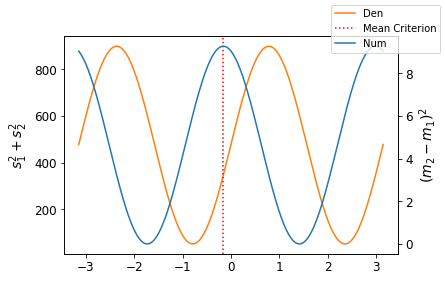

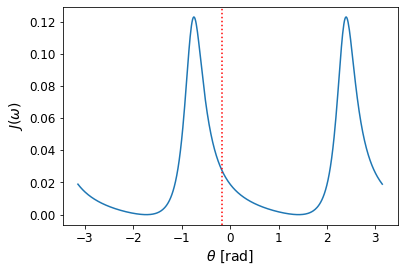

In [429]:
fig = plt.figure()

axd = fig.add_subplot(111)
axn = axd.twinx()

axn.plot(theta, num, label='Num')
axd.plot(theta, den, color='C1', label='Den')
axd.axvline(np.arctan2(w[1],w[0]), color='r', ls=':', label='Mean Criterion')
#
axn.set_xlabel(u'$\\theta$ [rad]')
axn.set_ylabel(u'$(m_2 - m_1)^2$')
axd.set_ylabel(u'$s_1^2 + s_2^2$')
fig.legend()

# Plotieamos el criterio de Fischer, J(w)
fig2 = plt.figure()
axj = fig2.add_subplot(111)
axj.plot(theta, num/den)
axj.axvline(np.arctan2(w[1],w[0]), color='r', ls=':', label='Mean Criterion')
axj.set_xlabel(u'$\\theta$ [rad]')
axj.set_ylabel(u'$J(\omega)$')


Vemos que el valor de $\theta$ que maximiza el numerador, no es el mismo que maximiza el criterio de Fischer (menos mal!). 

Busquemos a mano ese valor de theta y veamos el resultado.

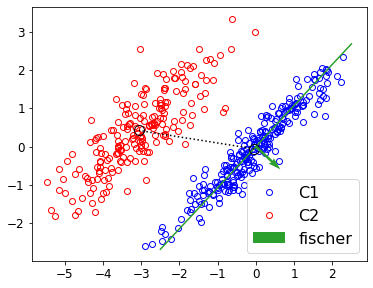

In [430]:
theta_fischer = theta[np.argmax(num/den)]
w_fischer = np.array([np.cos(theta_fischer), np.sin(theta_fischer)]).reshape(-1, 1)

plot_clasi(x, t, [w_fischer,], labels=['fischer',], xp=[-2.5, 2.5], spines=None)

Text(0.5, 0, '$y$')

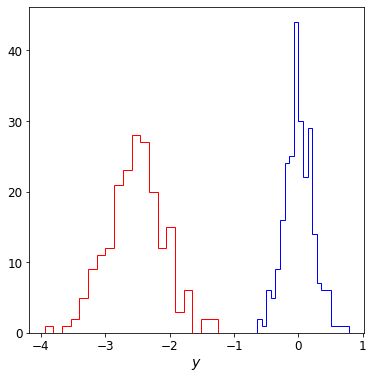

In [431]:
# Veamos la proyección de lo largo de esa dirección
y1 = np.dot(w_fischer.T, xc1)
y2 = np.dot(w_fischer.T, xc2)

# Veamos cómo se ven
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

nbins = 20
ax.hist(y1[0], nbins, histtype='step', color='b')
ax.hist(y2[0], nbins, histtype='step', color='r')

ax.set_xlabel('$y$')

Ah, hermoso!

### Solución analítica

¿Pero no podemos _calcular_ el $\om$ que minimiza el criterio de Fischer, en lugar de hacer una exploración numérica?

Claro que sí. Pero para eso tenemos que hacer aparecer de forma explícita $\om$ en la expresión (\ref{fischer1}) de arriba (para poder derivar):

$$
J(\om) = \frac{\left(m_2 - m_1\right)^2}{s_1^2 + s_2^2}\;\;.
$$

Si consideramos las definiciones de $m_k$ y $s_k^2$, metemos todo en esta expresion y reordenamos (Ejercicio 4.5 del Bishop), encontramos que:

\begin{equation}
J(\om) = \frac{\om\T\mathbf{S}_E\om}{\om\T\mathbf{S}_I\om}\;\;,
\label{fischer}
\end{equation}

donde $\mathbf{S}_E$ y $\mathbf{S}_I$ son las matrices de covarianza entre clases (**E**) e intraclases (**I**), respectivamente, con

$$
\mathbf{S}_E = (\mathbf{m}_2 - \mathbf{m}_1)(\mathbf{m}_2 - \mathbf{m}_1)\T
$$
y
$$
\mathbf{S}_I = \underbrace{\sum_{n\,\in\,\mathcal{C}_1} \left(\mathbf{x}_n - \mathbf{m}_1\right)\left(\mathbf{x}_n - \mathbf{m}_1\right)^\mathrm{T}}_{\text{Matriz de covarianza intra-clase 1}}
+ \underbrace{\sum_{n\,\in\,\mathcal{C}_2} \left(\mathbf{x}_n - \mathbf{m}_2\right)\left(\mathbf{x}_n - \mathbf{m}_2\right)^\mathrm{T}}_{\text{Matriz de covarianza intra-clase 2}}\;\;.
$$


Diferenciando la expresión $\ref{fischer}$ con respecto a $\om$ e igualando a cero, obtenemos que $J(\om)$ se maximiza cuando
$$
\om \propto \mathbf{S}^{-1}_I \left(\mathbf{m}_1 - \mathbf{m}_2\right)\;\;.
$$

Calculemos esto y comparemos con el cálculo numérico

In [432]:
dm = m1_ - m2_
S1 = np.dot(xc1 - m1, (xc1 - m1).T)
S2 = np.dot(xc2 - m1, (xc2 - m1).T)

# Matrix de covarianza intra-clase
Si = S1 + S2

# Encuentro omega resolviendo la ecuación
w_fischer_a = np.linalg.solve(Si, dm.reshape(-1, 1))

# normalizo
w_fischer_a /= np.sqrt(np.dot(w_fischer_a.T, w_fischer_a))
print(w_fischer_a)
print(w_fischer)

[[ 0.67532495]
 [-0.73752032]]
[[ 0.73223568]
 [-0.68105132]]


Ok, son parecidos....

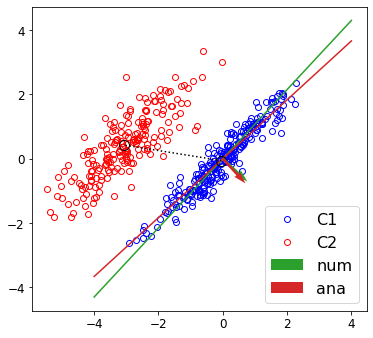

In [433]:
plot_clasi(x, t, [w_fischer, w_fischer_a], labels=['num', 'ana'], xp=[-4, 4], spines=None)

[[1.12381229]]


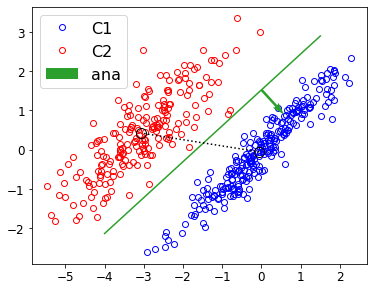

In [434]:
# Falta encontrar el omega0. Se puede hacer por cuadrados mínimos, usando valores de t específicos.
# ver Bishop Sect. 4.1.5
m_ = (xc1.shape[1] * m1_ + xc2.shape[1] * m2_) / (xc1.shape[1] + xc2.shape[1])

omega0 = -np.dot(w_fischer.T, m_)

print(omega0)

plot_clasi(x, t, [w_fischer_a,], labels=['ana'], xp=[-4, 1.5], spines=None, thr=-omega0[0])

## Perceptrón

Otra función discriminativa lineal es el perceptrón. Esta vez, se usa un criterio diferente. Se busca minimizar la función de error (o criterio) del perceptrón.

$$
E_P(\om) = -\sum_{n \in \mathcal{M}}\om\T \boldsymbol{\phi}(\mathbf{x}_n) \mathbf{t}_n\;\;,
$$
donde se usa el *encoding* $t \in \{-1, 1\}$, y la suma es sobre el conjunto $\mathcal{M}$ de los datos mal clasificados.

### Stochastic Gradient Descent (SGD)

Un algoritmo de optimización (es decir, para encontrar el vector de pesos $\om$ que minimiza $E(\om)$) que se usa frecuentemente es el *descenso por gradiente estocástico* (SGD).

En general, el agoritmo de descenso por gradiente consiste en modificar el vector de pesos en la dirección en la que disminuye más rápidamente la función de error ($E(\om)$). Es decir, el proceso iterativo

$$
\om^{(\tau + 1)} = \om^{(\tau)} - \eta \nabla E\left(\om^{(\tau)}\right)\;\;.
$$

El subíndice $\tau$ es un entero que indica en qué paso del proceso nos encontramos, y $\eta$ es la *tasa de aprendizaje* (*learning rate*), que controla cuán rápido nos movemos en la dirección del gradiente (usualmente se usa un valor inferior a 1). El algoritmo se inicia con un vector de pesos $\om^{(0)}$ y se procede hasta alcanzar la convergencia, que viene dada por un criterio de tolerancia, o hasta alcanzar el número máximo de iteraciones.

Fíjense que en cada paso del algoritmo hay que evaluar el gradiente de la función de error en la posición del nuevo vector de pesos $\om^{(\tau+1)}$, y para eso es necesario procesar el conjunto de entrenamiento entero. Esto puede ser costoso numéricamente, o directamente imposible, para grandes conjuntos de datos. Además, existen algoritmos de optimización más eficientes para optimización en *batch*.

Por otro lado, el algoritmo del descenso por gradiente puede adaptarse fácilmente para un aprendizaje *online* o secuencial, que resulta útil en la práctica. Se basa en el hecho de que la función de error se puede escribir como la suma de la función de error para cada punto del conjunto de entrenamiento:

$$
E(\om) = \sum_{n=1}^N E_n(\om)\;\;.
$$

Entonces, podemos actualizar el vector de pesos usando el gradiente de un solo punto de entrenamiento (o de un conjunto reducido), e ir pasando por todos los puntos del conjunto secuencialmente o al azar. En este caso, hablamos del algoritmo SGD:

$$
\om^{(\tau + 1)} = \om^{(\tau)} - \eta \nabla E_n\left(\om^{(\tau)}\right)\;\;,
$$

donde la única diferencia con lo de arriba es el subíndice $n$ en la función de error, que puede indicar el dato $n$ o algún subconjunto de datos.

### Optimización del perceptrón

En el caso particular del perceptrón, SGD toma una forma bien simpática y con una interpretación clara.

Considerando la expresión para el error del perceptrón, el SGD toma la forma:

$$
\om^{(\tau + 1)} = \om^{(\tau)} - \eta \nabla E_P\left(\om^{(\tau)}\right) = \om^{(\tau)} + \eta \boldsymbol{\phi}(\mathbf{x}_n) \mathbf{t}_n\;\;,
$$

y donde, como arriba, solo se consideran los puntos que están mal clasificados. Como el algoritmo es insensible frente a un cambio de escala de $\om$, en este caso podemos fijar $\eta = 1$ sin ninguna pérdida de generalidad.

Si un punto de la clase $\cu$ está mal clasificado, el vector de pesos se modifica sumando $\boldsymbol{\phi}(\mathbf{x}_n)$ a $\om$; si se trata de la clase $\cd$, se *resta* $\boldsymbol{\phi}(\mathbf{x}_n)$ a $\om$.

Vamos con un ejemplo en las diapositivas

***
*Tarea*: Encontrar la superficie de decisión para los datos que generamos arriba usando el modelo del perceptron
***

In [435]:
from sklearn.linear_model import Perceptron

perce = Perceptron(max_iter=1000)

# En ese caso, la matriz de diseño es simplemente, x
phi = x.T.copy()

# Pero podríamos probar otras cosas, como esto que está comentado más abajo.
perce = perce.fit(phi, t.flatten())

def makew(fitter):
    
    # # Obtengamos los pesos y normalicemos
    w = fitter.coef_.copy()
    
    # # Incluye intercept
#   w = np.vstack([fitter.intercept_[:, np.newaxis].copy(), w.T])
    # # Normalizon
    w /= np.linalg.norm(w)
    
    return w

w_perce = makew(perce).T
print(w_perce)

[[ 0.69054558]
 [-0.72328888]]


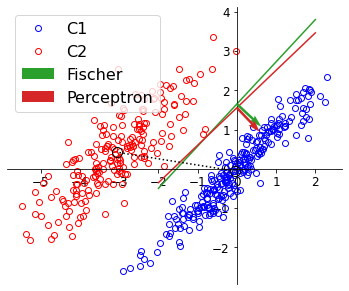

In [436]:
# Comparamos con Fischer
plot_clasi(x, t, [w_fischer, w_perce], ['Fischer', 'Perceptron'], xp=[-2, 2], thr=-omega0[0])

## Qué es linealmente separable

Ahora probamos lo mismo en un problema linealmente separable.

Text(0, 0.5, 'X_2')

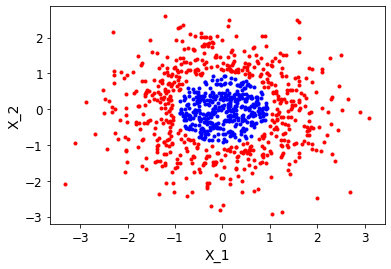

In [437]:
def make_circle_data():
    np.random.seed(2020)
    x = np.random.multivariate_normal(mean=[0,0], cov=[[1, 0],[0, 1]], size=1000).T
    r = (x[0]**2 + x[1]**2)

    xc1 = x[:, r < 0.9]
    xc2 = x[:, r > 1.1]
    
    # Uso coordenadas polares
    rc1 = np.sqrt(xc1[0]**2 + xc1[1]**2)
    thetac1 = np.arctan2(xc1[1], xc1[0])
    rc2 = np.sqrt(xc2[0]**2 + xc2[1]**2)
    thetac2 = np.arctan2(xc2[1], xc2[0])

    phi1 = np.vstack([rc1[np.newaxis, :], thetac1[np.newaxis, :]])
    phi2 = np.vstack([rc2[np.newaxis, :], thetac2[np.newaxis, :]])

#     phi1 = rc1[np.newaxis, :]
#     phi2 = rc2[np.newaxis, :]

    # Creamos la matrix de diseño completa y los labels
    t1 = np.ones_like(rc1)
    t2 = np.zeros_like(rc2)

    return xc1, xc2, phi1, phi2, t1, t2

xc1, xc2, phi1, phi2, t1, t2 = make_circle_data()
plt.plot(*xc1, '.b')
plt.plot(*xc2, '.r')
plt.xlabel('X_1')
plt.ylabel('X_2')

Estos datos son linealmente separables. Solo hay que elegir bien los features.

Text(0, 0.5, 'theta')

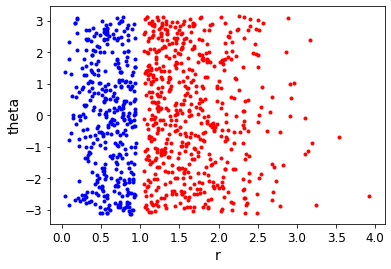

In [438]:
plt.plot(phi1[0], phi1[1], '.b')
plt.plot(phi2[0], phi2[1], '.r')
plt.xlabel('r')
plt.ylabel('theta')

In [439]:
# Creamos la matrix de diseño completa y los labels
#t1 = np.ones_like(rc1)
#t2 = -np.ones_like(rc2)

t = np.concatenate([t1, t2])
phi = np.vstack([phi1.T, phi2.T])

print(phi.shape)

(940, 2)


In [440]:
perce = Perceptron(max_iter=1000, tol=1e-10, fit_intercept=True)

# Fit data
perce.fit(phi, t)
w = makew(fitter)
print(w, perce.intercept_)

[[-0.99999158 -0.00410372]] [12.]


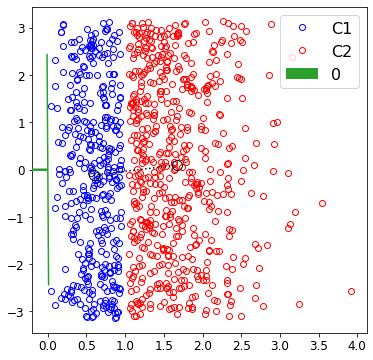

In [441]:
eps = 1e-8
plot_clasi(phi.T, t.reshape(1, -1), [w[0],], xp=[-1e-2, 1e-2], spines=None, equal=False)

In [442]:
from sklearn.model_selection import cross_val_predict


# Veamos que tal funcional
for l, f in zip(['Perceptron', ], [perce,]):
        
    y = cross_val_predict(f, phi, t, cv=5)

    print('Matriz de confusión para {}:\n'.format(l), confusion_matrix(y, t))

Matriz de confusión para Perceptron:
 [[564   0]
 [  0 376]]


Volvamos al espacio de input, $x1, x2$

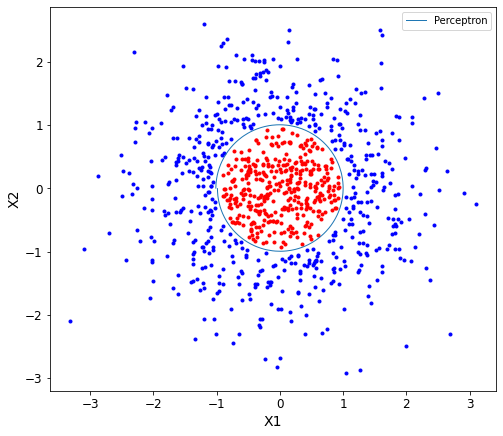

In [443]:
fig = plt.figure(figsize=(8, 8))
plt.plot(*xc1, '.r')
plt.plot(*xc2, '.b')
plt.gca().set_aspect('equal')
plt.xlabel('X1')
plt.ylabel('X2')

for ww, l in zip(w, ['Perceptron',]):
    
    # Puntos sobre el plano
    yp = phi[:, 1]
    xp = (1 - ww[1]*yp)/ww[0]

    # Convierto de vuelta al espacio x1 x2 (conservo el signo)
    signx1 = np.where((yp > -np.pi/2) * (yp <= np.pi/2), 1, -1)
    signx2 = np.where((yp > 0) * (yp <= np.pi), 1, -1)

    x1p = signx1 * np.sqrt(xp**2/(1 + np.tan(yp)**2))
    x2p = signx2 * np.sqrt(xp**2 - x1p**2)

    # Ploteo
    i = np.argsort(yp)
    plt.plot(x1p[i], x2p[i], '-', lw=1, label=l)
    
plt.legend()
# plt.xlim(-1.5, 1.5)
# plt.ylim(-1.5, 1.5)

> **Pregunta**: ¿Cómo cambian las matrices de confusión si achicamos el hueco entre las clases?

## Datos de MNIST

Vamos a usar un set de datos clásico de Machine Learning, los números de MNIST. Se trata de 70 000 imágenes pequeñas de dígitos escritos a mano. El "target" de cada uno de estos dígitos es el número que representan.

Este set de datos es tan común, que en <tt>sklearn</tt> hay una función que permite bajarlos directamente. Dependiendo de la versión que <tt>sklearn</tt> que estén usando, la función relevante del paquete <tt>datasets</tt> cambia. Además, cambia la forma en la que devuelven los datos (antes estaban ordenados por valor del *target*, ahora viene así nomás. Para que el resultado sea idéntico con ambas versiones, usamos este código, que nos presta amablemente Géron.

In [444]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [445]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

El resultado es un tipo que todavía no habíamos visto. No vamos a entrar en detalles, pero digamos que tiene los datos en el atributo data y los valores de los labels en el atributo target.

In [446]:
print(mnist.data.shape)
print(mnist.target.shape)

(70000, 784)
(70000,)


Los datos tienen 784 *features*, que corresponden a cada uno de los píxeles de las imágenes de 28 x 28. El valor oscila entre 0 (blanco) y 255 (negro). Veamos:

In [447]:
print(mnist.data[500])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  58. 121. 241. 254. 254. 254. 233. 109.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  63.
 178. 248. 253. 253. 253. 253. 253. 253. 252. 157.   0.   0.   0.   0.
   0. 

Separemos ahora datos de labels. Seguimos usando nuestra notación, en la que los labels se llaman *t*.

In [448]:
X, t = mnist["data"], mnist["target"]

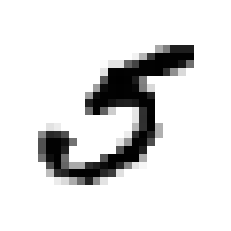

In [449]:
# Agarremos un dígito cualquiera
un_digito = X[36000]

# Lo ponemos en forma de imagen y lo vemos.
un_digito_image = un_digito.reshape(28, 28)
plt.imshow(un_digito_image, cmap = mpl.cm.binary,
           interpolation="None")
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

Es un cinco (creo). Confirmemos.

In [450]:
t[36000]

5

Lo que hicimos recién para plotear el número está piola. Vamos a convertirlo en una función para tener a mano.

In [451]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

Ahora veamos varios números. Usamos otro código que nos vuelve a prestar nuestro amigo Aurélien.

In [452]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

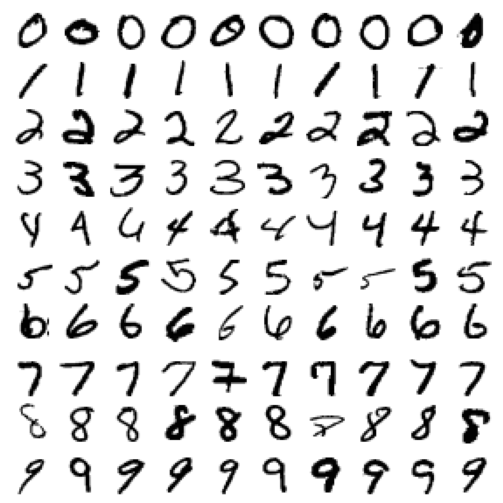

In [453]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

Antes de seguir mirando, tenemos que separar el conjunto en entrenamiento y testeo. Por suerte, los datos MNIST ya vienen separados, de forma de tener buena representación de cada clase. Las primeras 60000 instancias son de entrenamiento y las últimas 10000 de testeo.

In [454]:
X_train, X_test, t_train, t_test = X[:60000], X[60000:], t[:60000], t[60000:]

Vamos a barajar el conjunto de entrenamiento. Esto es para asegurarse de que todos los dígitos estarán bien representandos en distintos *folds* de validación cruzada.

In [455]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, t_train = X_train[shuffle_index], t_train[shuffle_index]

<a id='binary'></a>
### Clasificación binaria

Vamos a empezar haciendo las cosas fáciles y dividir el problema. Vamos a intentar detectar "cincos". Para eso, generamos un nuevo label, que sea 1 cuando el número es cinco, y cero cuando no lo sea. Obviamente, hacemos lo mismo para el test.

In [456]:
t_train_5 = (t_train == 5)
t_test_5 = (t_test == 5)

In [457]:
t_train_5[:100]

array([False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False,  True,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False])

<tt>sklearn</tt> tiene una clase <tt>Perceptron</tt>, que es la que vamos a usar.

In [458]:
from sklearn.linear_model import Perceptron

perce = Perceptron()

# Hagamos un fit usando como features los valores de los píxeles directamente (linear regression)
# En ese caso, la matriz de diseño es simplemente, Xtrain
phi = X_train.copy()

# Pero podríamos probar otras cosas, como esto que está comentado más abajo.
#phi = np.log(1 + X_train.copy()**2)
perce = perce.fit(phi, t_train_5)

In [459]:
print('Perceptron says', perce.predict([un_digito]))
# print('Logistic regression says', logi.predict([un_digito]))

Perceptron says [ True]


Bueno, parece que ese cinco raro lo identifica correctamente. Pero claro, estaba dentro del conjunto de entrenamiento. Esto no quiere decir absolutamente nada.

***
**Pregunta**: ¿O sí?
***

In [460]:
from sklearn.model_selection import cross_val_score
#cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
scores = cross_val_score(perce, X_train, t_train_5, cv=5, scoring="accuracy")
print(scores)
print(scores.mean())

[0.94725    0.96383333 0.95741667 0.96125    0.96808333]
0.9595666666666667


Esto parece increíble. Más del 96% de "accuracy", con un modelo lineal muy simple. ¿Es posible?

***
**Pregunta**: Pensemos un poco más en detenimiento, considerando la naturaleza del dataset. ¿Es realmente un valor tan alto? ¿Qué pasaría si hicieramos un clasificador que dijera que el número nunca es cinco?
***

En efecto, en este tipo de datasets, donde los datos están muy desbalanceados, no es muy útil la "accuracy". Es mejor usar la matriz de confusión.

Para crearla, neceistamos calcular predicciones en cada uno de nuestras instancias de entrenamiento, si queremos evitar usar el conjunto de test. En ese caso, podemos hacer CV y calcular las predicciones en cada uno de los folds. Eso lo hace una función de <tt>sklearn</tt> (gracias por tanto!), aunque la implementación no sería complicada.

In [461]:
from sklearn.model_selection import cross_val_predict

t_train_pred_perce = cross_val_predict(perce, phi, t_train_5, cv=5)
# t_train_pred_logi = cross_val_predict(logi, phi, t_train_5, cv=5)

In [462]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(t_train_5, t_train_pred_perce)
print(cm)

[[53621   958]
 [ 1468  3953]]


Con estos valores en mano, podemos calcular el exhaustividad (*recall*) y la precisión.

Recordemos:

$$
\mathrm{precision} = \frac{TP}{TP + FP}
$$

$$
\mathrm{recall} = \frac{TP}{TP + FN}
$$

donde TP son los *true positives* (es decir, la cantidad de casos relevantes recuperados correctamente), FP son los *falsos positivos* (es decir, la cantidad de casos no relevante recuperados incorrectamente), y FN son los *falsos negativos* (es decir, la cantidad de casos relevantes **no** recuperados).

Calculemos estas cosas

In [463]:
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]

print('Precision: ', tp/(tp + fp))
print('Recall: ',  tp/(tp + fn))

Precision:  0.8049277132966809
Recall:  0.7292012543811105


Estos resultados hay que interpretarlos de la siguiente manera: la precisión nos dice en qué fracción de los casos en los que perceptrón dice que tiene un "5", realmente lo tiene. Además, el *recall* nos dice que fracción de todos los "5" encontró.

Uno puede, en principio, ajustar estos valores mirando el nivel del umbral que usa para clasificar una instancia como verdadera o no. Como vimos, por defecto esto es $y(\mathbf{x}) = 0$ para el perceptron, pero podemos cambiarlo. Para eso, necesitamos el perceptron nos diga el valor de $y(\mathbf{x_k})$, para cada imagen $x_k$

In [464]:
# Podríamos hacer así
y = perce.decision_function(X_train)

# Pero mejor sería hacerlo con CV, usando 5 folds
y = cross_val_predict(perce, X_train, t_train_5, cv=3, method="decision_function")

Text(0.5, 0, 'y(x)')

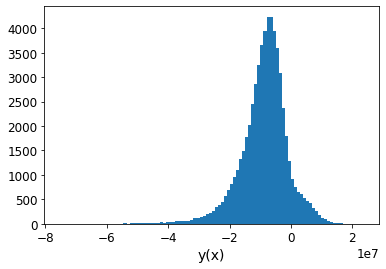

In [465]:
# Veamos cómo se ven
A = plt.hist(y, 100)
plt.xlabel('y(x)')

Ahora hagamos un código que vaya variando el umbral y nos calcule la precisión y el recall.

In [466]:
umb = np.linspace(y.min()-1, y.max()+1, 5000)

recall = np.zeros_like(umb)
precision = np.zeros_like(umb)
fpr = np.zeros_like(umb)

for i, u in enumerate(umb):
    
    # Calcula los índices con detecciones para este umbral
    det = y > u
    
    # Compara esto con los verdaderos casos en esos índices

    tp = np.sum(t_train_5[det] == True)
    # Falsos positivos
    fp = np.sum(t_train_5[det] == False)

    # Verdaderos y falsos negativos
    tn = np.sum(t_train_5[~det] == False)
    fn = np.sum(t_train_5[~det] == True)
    
    recall[i] = tp/(tp + fn)
    precision[i] = tp/(tp + fp)
    fpr[i] = fp/(fp + tn)

<ipython-input-466-c62c267e8123>:23: RuntimeWarning: invalid value encountered in long_scalars
  precision[i] = tp/(tp + fp)


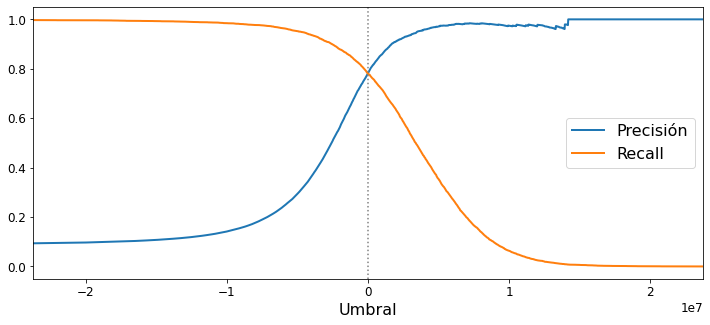

In [467]:
fig = plt.figure(figsize=(12, 5))
plt.plot(umb, precision, label='Precisión', lw=2)
plt.plot(umb, recall, label='Recall', lw=2)
plt.xlabel("Umbral", fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.xlim(-umb.max(), umb.max())
plt.axvline(0.0, ls=':', color='0.5')

Se puede plotear directo uno vs. el otro:

Text(0.5, 1.0, 'Curva PR')

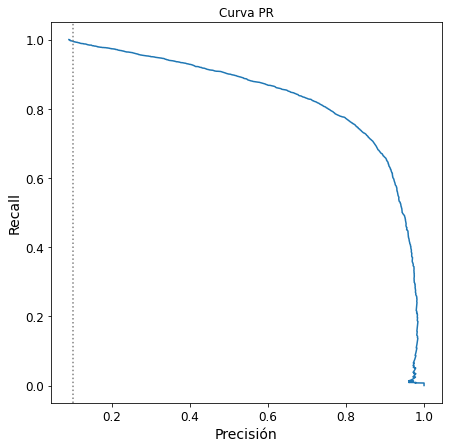

In [468]:
fig = plt.figure(figsize=(7, 7))
plt.plot(precision, recall)
plt.axvline(0.1, ls=':', color='0.5')
plt.xlabel('Precisión')
plt.ylabel('Recall')
plt.title('Curva PR')

Otra forma de ver esto es con la curva ROC (Receiver Operating Characteristic, o Característica Operativa del Receptor), que es muy similar, salvo que plotea la tasa de verdaderos positivos (es decir, el recall, en función de la tasa de falsos positivos). Cuanto más alejado de la recta unidad esté el sistema mejor, pero por supuesto esto depende del problema a resolver.

Text(0.5, 1.0, 'Curva ROC')

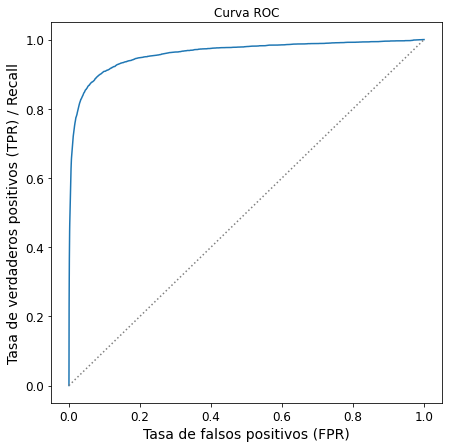

In [469]:
fig = plt.figure(figsize=(7, 7))
plt.plot(fpr, recall)
plt.plot([0, 1], [0, 1], color='0.5', ls=':')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR) / Recall')
plt.title('Curva ROC')

Otra característica interesante es el area bajo la curva. Podemos hacer una estimación veloz, sumando:

In [470]:
np.sum(recall[1:] * np.diff(fpr))

-0.9603768050846478

Hay código de <tt>sklearn</tt> para todo esto.

In [471]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
precisions, recalls, thresholds = precision_recall_curve(t_train_5, y)
fpr, tpr, thresholds = roc_curve(t_train_5, y)
print(roc_auc_score(t_train_5, y))

0.9604781476350787


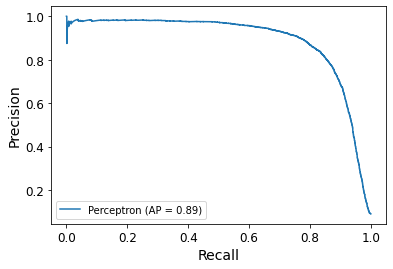

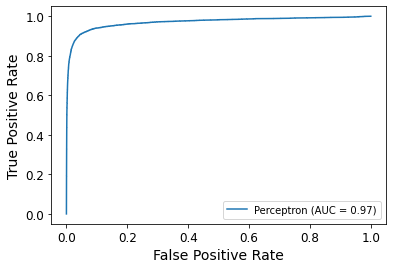

In [475]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
plot_precision_recall_curve(perce, X_train, t_train_5)
plot_roc_curve(perce, X_train, t_train_5)

<a id='extras'></a>
### Extras

¿Cómo se verá el cinco promedio?

In [ ]:
cinco = X_train[t_train==5].mean(axis=0)

In [ ]:
plot_digit(cinco)
plt.colorbar()

¿Qué distribución tienen los pesos en la imagen?

In [ ]:
plot_digit(perce.coef_[0])